# Sprint21課題 セグメンテーション2

## 【問題1】コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行ってください。

視点例

Sprint20で使用した実装とはどのように違うのか
転移学習をどのように行っているか
[kernel](https://www.kaggle.com/wrosinski/clean-workflow-in-keras)

概要
* EncoderはU-netでなくResNet50の物を使っている。Decoderのみを定義している

* DecoderはConvolution, BatchNormalizationとParametrized ReLU　activationからなっている

* Contracting pathはEncoderであるResNet50のactivation_1, activation_10, activation_22, activation_40, activation_49からDecoderの各層に伸びている。

<br>
詳細はコードの中にコメントしていく

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Kaggleからデータセット落とすためのコード

In [0]:
!mkdir /root/kaggle
!mv /root/kaggle /root/.kaggle

In [0]:
!mv /content/drive/My\ Drive/kaggle.json /root/.kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c tgs-salt-identification-challenge 

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 47.1MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 71.9MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 61.1MB/s]
 97% 159M/163M [00:02<00:00, 82.4MB/s]
100% 163M/163M [00:02<00:00, 62.9MB/s]
 87% 33.0M/37.9M [00:00<00:00, 18.2MB/s]
100% 37.9M/37.9M [00:01<00:00, 39.1MB/s]


In [6]:
!mkdir /content/data
!mv /content/* /content/data

mv: cannot move '/content/data' to a subdirectory of itself, '/content/data/data'
mv: cannot move '/content/drive' to '/content/data/drive': Device or resource busy


In [ ]:
!unzip /content/data/train.zip -d train
!unzip /content/data/test.zip -d test

### Model architecture tuning & score optimization

In [8]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input

%matplotlib inline

Using TensorFlow backend.


In [0]:
plt.rcParams['figure.figsize'] = (12, 9)

In [0]:
def compute_coverage(df, masks):
        """
        df: data frame
            retaining img id
        masks: target img(mask)
            target masks showing salt part in white while other part in black
        """
        df = df.copy()
        
        #11のclassに分類
        def cov_to_class(val):
                for i in range(0, 11):
                        if (val * 10 <= i):
                                return i
        #output percentage of area covered by class
        #maskは0 or 1の白黒画像なので平均がPercentageになる
        df['coverage'] = np.mean(masks, axis=(1, 2))
        #coverage must be split into bins, otherwise stratified split will not be possible
        #because each coverage will occur only once.
        
        #塩の比率(coverage)に応じて地層のクラス分け(0-11の11段階)
        #map関数でdf.coverageの各要素をcov_to_classに渡し、その返り値を受け取る
        df['coverage_class']  = df.coverage.map(cov_to_class)
        #塩の比率とクラスを付加したdfを返却
        return df

def create_depth_abs_channels(image_tensor):
        #float型に
        image_tensor = image_tensor.astype(np.float32)
        #height, width, chennelの数
        h, w, c = image_tensor.shape
        
        #linspaceで0-1までをh分割した配列を作成
        #行番号（row）とそのrowの値（const）に関してloop
        for row, const in enumerate(np.linspace(0, 1, h)):
                #image_tensorのchannel 1に1/hを代入
                image_tensor[row, :, 1] = const
        #channel 0（画像のデータ）に　channel 1(1/h)をかけてimage_tensorのchannel 2にとする
        #つまり、画像を地層の深さで割ったということ?（圧力による影響を加味?）
        image_tensor[:, :, 2] = (image_tensor[:, :, 0] * image_tensor[:, :, 1])
        
        #height方向の差分(差があるところ（境界）を浮かび上がらせる?)
        x_dx = np.diff(image_tensor[:, :, 0], axis=0)
        #width方向の差分
        x_dy = np.diff(image_tensor[:, :, 0], axis=1)
        #diffで１列（行）だけ欠けるのでその分を埋める
        x_dx = cv2.copyMakeBorder(
            src=x_dx,
            top=1, bottom=0, left=0, right=0,
            borderType=cv2.BORDER_CONSTANT,
            value=0
        )
        x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
        #横と縦方向のdiffを足し合わせてで１列（行）だけ欠けるのでその分を埋める
        image_tensor[:, :, 1] = np.abs(x_dx + x_dy)
        
        return image_tensor
        

### Data loading & depth merge

In [11]:
train = pd.read_csv('/content/data/train.csv')
test = pd.read_csv('/content/data/sample_submission.csv')
depth = pd.read_csv('/content/data/depths.csv')

train_src = '../input/train'

print('train:\n{}'.format(train.head()))
print('\ntest\n{}'.format(test.head()))

train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))


train:
           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...

test
           id rle_mask
0  155410d6fa      1 1
1  78b32781d1      1 1
2  63db2a476a      1 1
3  17bfcdb967      1 1
4  7ea0fd3c88      1 1

           id                                           rle_mask    z
0  575d24d81d                                                NaN  843
1  a266a2a9df                                          5051 5151  794
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  468
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  727
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...  797


### Load images and masks, examine random sample

In [12]:
X_train = np.asarray(
        [cv2.imread('/content/train/images/{}.png'.format(x), 0) for x in train.id.tolist()],
        dtype=np.uint8
) /255.0

y_train = np.asarray(
    [cv2.imread('/content/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
        dtype=np.uint8
) / 255.0

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


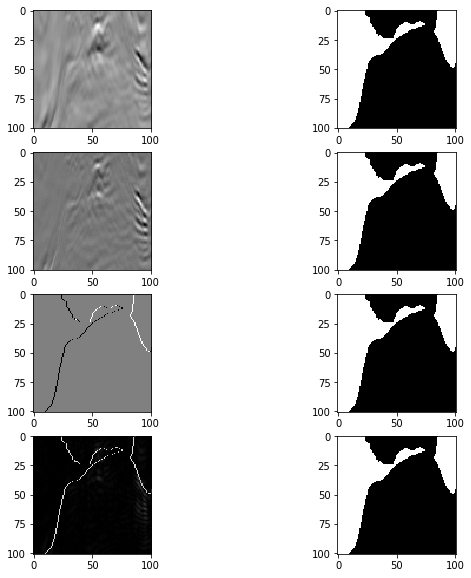

In [13]:
#ランダムに選んで描画
random_index = np.random.randint(0, X_train.shape[0])

x_ = X_train[random_index]
y_ = y_train[random_index]

x_dx = np.diff(x_, axis=0)
x_dy = np.diff(y_, axis=1)
#diffで１列（行）だけ欠けるのでその分を埋める
x_dx = cv2.copyMakeBorder(
    src=x_dx,
    top=1, bottom=0, left=0, right=0,
    borderType=cv2.BORDER_CONSTANT,
    value=0
)
x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)

fig, ax = plt.subplots(4, 2, figsize=(10, 10))
ax[0, 0].imshow(x_, cmap='gray')
ax[0, 1].imshow(y_, cmap='gray')

ax[1, 0].imshow(x_dx, cmap='gray')
ax[1, 1].imshow(y_, cmap='gray')

ax[2, 0].imshow(x_dy, cmap='gray')
ax[2, 1].imshow(y_, cmap='gray')

ax[3, 0].imshow(np.abs(x_dx + x_dy), cmap='gray')
ax[3, 1].imshow(y_, cmap='gray')

### Compute salt coverage (this will serve as basis of stratified split)

In [0]:
#masksの塩の部分に地層に占める塩の比率と、それに応じた0-10のクラス分けをtrainのdata frameに追加
train = compute_coverage(df=train, masks=y_train)

### Prepare data for training

In [15]:
#全体に占める0-10のクラスの比率を維持したままK分割
kfold = StratifiedKFold(n_splits=5, random_state=1337)

#add channel features

#channel成分の軸を足して、3回 repeatして3channel追加
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)

#X_train_chの各要素をcreate_depth_abs_channelsに渡して、その返り値をlist化
X_train_ch = np.asarray(
    list(map(lambda x: create_depth_abs_channels(x), X_train_ch))
)

#resize to 224x224, default ResNet50 image size
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))

for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
        X_tr, X_val = X_resized[train_index], X_resized[valid_index]
        y_tr, y_val = y_resized[train_index], y_resized[valid_index]
        
        break

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

#delete to release memory
del X_train_ch, y_resized
del X_resized
#print released memory (MB)
gc.collect()

(3196, 224, 224, 3) (3196, 224, 224, 1)
(804, 224, 224, 3) (804, 224, 224, 1)


47

### Loss functions & metric

In [0]:
from keras.losses import binary_crossentropy


#Dice & combined
def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred = K.cast(y_pred, 'float32')
        y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
        intersection = y_true_f * y_pred_f
        score = 2.0 * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
        return score

def dice_loss(y_true, y_pred):
        smooth = 1.0
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = y_true_f * y_pred_f
        score = (2.0 * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return 1.0 -  score
    
def bce_dice_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) - K.log(1.0 - dice_loss(y_true, y_pred))

# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
        """
        computes gradient of the Lovasz extension with respect to sorted errorsd
        """
        gts = tf.reduce_sum(gt_sorted)
        intersection = gts - tf.cumsum(gt_sorted)
        union = gts + tf.cumsum(1.0 - gt_sorted)
        jaccard = 1.0 - intersection / union
        jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
        return jaccard

#binary loss
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
        """
        Binary Lovasz hinge loss
        logits: [B, H, W] variable, logits at each pixel (between -\infty and + \infty)
        labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
        per_image: compute the loss per image instead of per batch
        ignore: void class id
        """
        if per_image:
                def treat_image(log_lab):
                        log, lab = log_lab
                        log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
                        log, lab = flattend_binary_scores(log, lab, ignore)
                        return lovasz_hinge_flat(log, lab)
                losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
                loss = tf.reduce_mean(losses)
        else:
                loss = lovasz_hinge_flat(*flattend_binary_scores(logits, labels, ignore))
        return loss
    
def lovasz_hinge_flat(logits, labels):
        """
        binary lovasz hinge loss
            logits: [P] Variable, logits as each prediciton (between -\infty and +\infty)
            labels: [P] Tensor, binary ground truth labels ( 0 or 1)
            ignore: label to ignore
        """
        
        def compute_loss():
                labelsf = tf.cast(labels, logits.dtype)
                signs = 2.0 * labelsf - 1.0
                errors = 1.0 - logits * tf.stop_gradient(signs)
                errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
                gt_sorted = tf.gather(labelsf, perm)
                grad = lovasz_grad(gt_sorted)
                loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
                return loss
        
        #deal with the void prediction case (only void pixels)
        loss = tf.cond(
                tf.equal(tf.shape(logits)[0], 0),
                lambda: tf.reduce_sum(logits) * 0.0,
                compute_loss,
                strict=True,
                name='loss'
        )
        return loss
    
def flatten_binary_scores(scores, labels, ignore=None):
        """
        Flattens predictions in the batch (binary case)
        Remove labels equal to 'ignore'
        """
        
        scores = tf.reshape(scores, (-1, ))
        labels = tf.reshape(labels, (-1, ))
        if ignore is None:
                return scores, labels
        valid = tf.not_equal(labels, ignore)
        vscores = tf.boolean_mask(scores, valid, name='valid_scores')
        vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
        return vscores, vlabels
def lovasz_loss(y_true, y_pred):
        y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
        #logits = K.log(y_pred / (1.0 - y_pred))
        logits = y_pred #jiaxin
        loss = lovasz_hinge(logits, y_true, per_image=True, ignore=None)
        return loss

#IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
        """
        A: ndarray of shape()
            label
        B:
            pred
        """
        batch_size = A.shape[0]
        metric = 0.0
        for batch in range(batch_size):
                t, p = A[batch], B[batch]
                true = np.sum(t)
                pred = np.sum(p)
                
                #deal with empty mask first
                if (true == 0):
                        metric += (pred==0)
                        continue
                #non empty mask case. Union is never empty
                #hence it is safe to divide by its number of pixels
                intersection = np.sum(t*p)
                union = true + pred - intersection
                iou = intersection / union
                
                #iou metric is a stepwise approximation of the real iou over 0.5
                iou = np.floor(max(0, (iou - 0.45)*20)) / 10
                metric += iou
        
        #take the average over all images in batch
        metric /= batch_size
        return metric
    
def my_iou_metric(label, pred):
        return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

#for lovash loss
#funcにinp（input）のTensorを渡すとOutputのTensorをToutの形式で返してくれる
def my_iou_metric_2(label, pred):
        return tf.py_func(func=get_iou_vector, inp=[label, pred > 0], Tout=tf.float64)

### Encoder features - ResNet50
In ResNet50, each block finishes with a poolimg layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers. Defalut input size will be assumed, which is (224, 224, 3). Layers will be as follows:
* 'activation_1', shape: (None, 112, 112, 64)
* 'activation_10', shape: (None, 56, 56, 256)
* 'activation_22', shape: (None, 28, 28, 512)
* 'activation_40', shape: (None, 14, 14, 1024)
* 'activation_49', shape: (None, 7, 7, 2048)

One thing to keep in mind is that every time a model is created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call `K.clear_session()`

### Decoder blocks
Featurea from ResNet50 will serve as a basis for encoder part of the segmentaion model, now a decoder part is needed. For this part, we will have to create our own blocks. Let's create a very basic block and a second one, the tructure of which will be more complicated.

In [0]:
#encoderはResNet50の物を使う。Decoderのみを定義

#Basic decoder block with Conv, BN and Parametrized ReLU　activation
def decoder_block_simple(layer_name, block_name, n_filters=32, conv_dim=(3, 3)):
       #特に指定していないので、重みはglorot_uniform(一様乱数での初期化)
        x_dec = Conv2D(
            filters=n_filters, kernel_size=conv_dim, padding='same',
            name='{}_conv'.format(block_name))(layer_name)
        
        x_dec = BatchNormalization(
            name='{}_bn'.format(block_name))(x_dec)
        
        x_dec = PReLU(
            name='{}_activation'.format(block_name))(x_dec)
        
        return x_dec

#decoder block with bottlenech architecture, where middle conv layer 
#is half the size of first and last, in order to compress representaion.
#This type of architecture is supposed to retain most useful information
def decoder_block_bottleneck(
    layer_name, block_name, n_filters=32, conv_dim=(3, 3), dropout_frac=0.2):
    
        x_dec = Conv2D(
            filters=n_filters, kernel_size=conv_dim,
            padding='same', name='{}_conv1'.format(block_name))(layer_name)
        x_dec = BatchNormalization(
            name='{}_bn1'.format(block_name))(x_dec)
        x_dec = PReLU(
            name='{}_activation1'.format(block_name))(x_dec)
        x_dec = Dropout(dropout_frac)(x_dec)
        
        x_dec2 = Conv2D(
            n_filters//2, conv_dim, padding='same',
            name='{}_conv2'.format(block_name))(x_dec)
        x_dec2 = BatchNormalization(
            name='{}_bn2'.format(block_name))(x_dec2)
        x_dec2 = PReLU(
            name='{}_activation2'.format(block_name))(x_dec2)
        x_dec2 = Dropout(dropout_frac)(x_dec2)
        
        x_dec2 = Conv2D(
            n_filters, conv_dim, padding='same',
            name='{}_conv3'.format(block_name))(x_dec2)
        x_dec2 = BatchNormalization(
            name='{}_bn3'.format(block_name))(x_dec2)
        x_dec2 = PReLU(
            name='{}_activation3'.format(block_name))(x_dec2)
        x_dec2 = Dropout(dropout_frac)(x_dec2)
        x_dec2 = Add()([x_dec, x_dec2])
        
        return x_dec2

### Model definition
Combine encoder and decoder blocks to create final segmentation model.

In [0]:
#model is parametrized in a way to enable easy change of decoder_block type,
#as this is an argument that ccan be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block, weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False
               ):
        # weights='imagenet'でResNetの部分はimagenetのデータでの学習を利用しての転移学習
        #base model - encoder
        base_model = ResNet50(
                input_shape=input_size,
                include_top=False,
                weights=weights
        )
        
        #Layers for feature extraction in the encoder part
        encoder1 = base_model.get_layer('activation_1').output#112, 112, 64
        encoder2 = base_model.get_layer('activation_10').output#56, 56, 256
        encoder3 = base_model.get_layer('activation_22').output#28, 28, 512
        encoder4 = base_model.get_layer('activation_40').output#14, 14, 1024
        encoder5 = base_model.get_layer('activation_49').output#7, 7, 2048
        
        #Center block
        center = decoder_block(#7, 7, 512
                layer_name=encoder5, block_name='center',
                n_filters=512, conv_dim=(3, 3)
        )
        concat5 = concatenate([center, encoder5], axis=-1)
        
        #Decoder part
        #Every decoder block processed concatenated output from encoder and decoder part.
        #This creates skip connections
        #Afterwards, decoder output is upsampled to dimensions equal to encoder output part
        decoder4 = decoder_block(#7, 7, 256#Upsamplingで(2, 2)の4倍に
            layer_name=concat5, block_name='decoder4', n_filters=256, conv_dim=(3, 3)
        )
        concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)
        
        decoder3 = decoder_block(#14, 14, 128#Upsamplingで(2, 2)の4倍に
            layer_name=concat4, block_name='decoder3', n_filters=128, conv_dim=(3, 3)
        )
        concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)
        
        decoder2 = decoder_block(#28, 28, 64#Upsamplingで(2, 2)の4倍に
            layer_name=concat3, block_name='decoder2', n_filters=64, conv_dim=(3, 3)
        )
        concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)
        
        decoder1 = decoder_block(#56, 56, 64#Upsamplingで(2, 2)の4倍に
            layer_name=concat2, block_name='decoder1',  n_filters=64, conv_dim=(3, 3)
        )
        concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)
        
        #Final upsampling and decoder block for segmentation
        
        output = UpSampling2D()(concat1)
        output = decoder_block(
            layer_name=output, block_name='decoder_output', n_filters=32, conv_dim=(3, 3)
        )
        output = Conv2D(
             filters=1, kernel_size=(1, 1), activation=None, name='prediction')(output)
        
        if not use_lovash:
                output = Activation('sigmoid')(output)
        
        model = Model(base_model.input, output)
        model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)
        
        return model

### Inspect created model

In [20]:
input_size = (224, 224, 3)

K.clear_session()
model = unet_resnet(
        input_size=input_size, decoder_block=decoder_block_simple, weights='imagenet'
)
model.summary()

W0723 11:24:18.917534 139858354980736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0723 11:24:18.920032 139858354980736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 11:24:18.967782 139858354980736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 11:24:18.969259 139858354980736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W072

94658560/94653016 [==============================] - 8s 0us/step


W0723 11:24:41.473400 139858354980736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0723 11:24:41.987520 139858354980736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 11:24:42.021452 139858354980736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0723 11:24:42.045238 139858354980736 deprecation.py:323] From <ipython-input-17-96a668420011>:144: py_func (from tensorflow.python.o

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Train model

In [22]:
K.clear_session()

#Build mode:
#Here you can experiment with various losses.
#For dice and BCE(binary_crossentropy), my_iou_metric should be used,
#whereas for lovash_loss my_iou_metric2 should be used, because range of value
#for  lovash loss is between -infty and + infty, not between 0 and 1, as for BCE and dice
#What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
#This is controlled by use_lovash parameter.

model_depth = unet_resnet(
        input_size=input_size, decoder_block=decoder_block_bottleneck,
        weights='imagenet', loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
        use_lovash=False
)

#print(model_depth.summary())

#bestなepoch回数での結果をcheck_pointに保管するためのModelCheckpointクラスのインスタンス
model_checkpoint = ModelCheckpoint(
        'unet_resnet.h5', monitor='val_my_iou_metrics', mode='max',
        save_best_only=True, save_weights_only=True, verbose=True
)
#評価値の改善が止まった時に学習率を減少
reduce_lr = ReduceLROnPlateau(
        monitor='val_my_iou_metric',
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-4,
        verbose=True
)

epochs = 10
batch_size = 16

history = model_depth.fit(
        X_tr, y_tr, validation_data=[X_val, y_val],
        epochs=epochs, batch_size=batch_size,
        callbacks=[model_checkpoint, reduce_lr],
        verbose=True
)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W0723 11:25:08.143246 139858354980736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 3196 samples, validate on 804 samples
Epoch 1/10
3196/3196 [==============================] - 268s 84ms/step - loss: 0.8099 - my_iou_metric: 0.3086 - val_loss: 1.0345 - val_my_iou_metric: 0.3847


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_my_iou_metrics available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10
3196/3196 [==============================] - 237s 74ms/step - loss: 0.6526 - my_iou_metric: 0.4534 - val_loss: 1.5033 - val_my_iou_metric: 0.0985
Epoch 3/10
3196/3196 [==============================] - 237s 74ms/step - loss: 0.5926 - my_iou_metric: 0.4686 - val_loss: 0.5783 - val_my_iou_metric: 0.5703
Epoch 4/10
3196/3196 [==============================] - 237s 74ms/step - loss: 0.5078 - my_iou_metric: 0.5410 - val_loss: 0.5332 - val_my_iou_metric: 0.5794
Epoch 5/10
3196/3196 [==============================] - 237s 74ms/step - loss: 0.4954 - my_iou_metric: 0.5645 - val_loss: 0.4659 - val_my_iou_metric: 0.6301
Epoch 6/10
3196/3196 [==============================] - 237s 74ms/step - loss: 0.4307 - my_iou_metric: 0.5839 - val_loss: 0.4477 - val_my_iou_metric: 0.6282
Epoch 7/10
3196/3196 [==============================] - 237s 74ms/step - loss: 0.4209 - my_iou_metric: 0.5890 - val_loss: 0.5471 - val_my_iou_metric: 0.5387
Epoch 8/10
3196/3196 [==============================] - 23

### Validation set prediction and resizing to original size

In [0]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

### Threshold optimization

$$
IoU = \frac{Intersection}{Union}
$$
<img src='https://mathwords.net/wp-content/uploads/2019/02/iou1.png' width="120px">

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
#IoU = tp/(tp+tn+fn)
def iou_metric(y_true_in, y_pred_in, print_table=True):
        labels= y_true_in
        y_pred = y_pred_in
        
        true_objects = 2
        pred_objects = 2
        
        intersection = np.histogram2d(
            labels.flatten(), y_pred.flatten(),
            bins=(true_objects, pred_objects))[0]
        
        #compute areas (needed for finding the union between all objects)
        #ヒストグラム（度数=class数）でカウントしている
        area_true = np.histogram(labels, bins=true_objects)[0]
        area_pred = np.histogram(y_pred, bins=pred_objects)[0]
        area_true = np.expand_dims(area_true,-1)
        area_pred = np.expand_dims(area_pred,0)
        
        #compute union
        #(A ∪ B) = A + B - (A ∩ B ) 
        union = area_true + area_pred - intersection
        
        #Exclude background from the analysis
        intersection = intersection[1:, 1:]
        union = union[1:, 1:]
        union[union == 0] = 1e-9
        
        #Compute the intersection over union
        iou = intersection / union
        
        #Precision helper function
        def precision_at(threshold, iou):
                matches = iou > threshold
                true_positives = np.sum(matches, axis=1) == 1
                false_positives = np.sum(matches, axis=0) == 0
                false_negatives = np.sum(matches, axis=1) == 0
                tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
                return tp, fp, fn

        #Loop over IoU thresholds
        prec = []

        if (print_table):
                print("Thresh\tTP\tFP\tFN\tPrec,")
        for t in np.arange(0.5, 1.0, 0.05):
                tp, fp, fn = precision_at(t, iou)
                if ((tp + fp + fn) > 0):
                        p = tp/(tp + fp + fn)
                else:
                        p = 0
                if (print_table):
                        print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
                prec.append(p)

        if (print_table):
                print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
        return np.mean(prec)
def iou_metric_batch(y_true_in, y_pred_in):
        batch_size = y_true_in.shape[0]
        metric = []
        for batch in range(batch_size):
                value = iou_metric(y_true_in[batch], y_pred_in[batch], print_table=False)
                metric.append(value)
        return np.mean(metric)
        

In [25]:
#Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

#For every threshold, set predictions to binary arrays,
#where values above threshold are treated as 1 and the rest as 0.
#Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true, np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)]
)

100%|██████████| 35/35 [00:49<00:00,  1.42s/it]


In [26]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

#Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]
))

#Describe IoU DF
df_iou.describe()

Best IoU: 0.5910 at threshold: 0.880


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.541592
std,0.204939,0.032441
min,0.200000,0.485075
25%,0.370000,0.514117
50%,0.540000,0.539428
75%,0.710000,0.571020
max,0.880000,0.591045


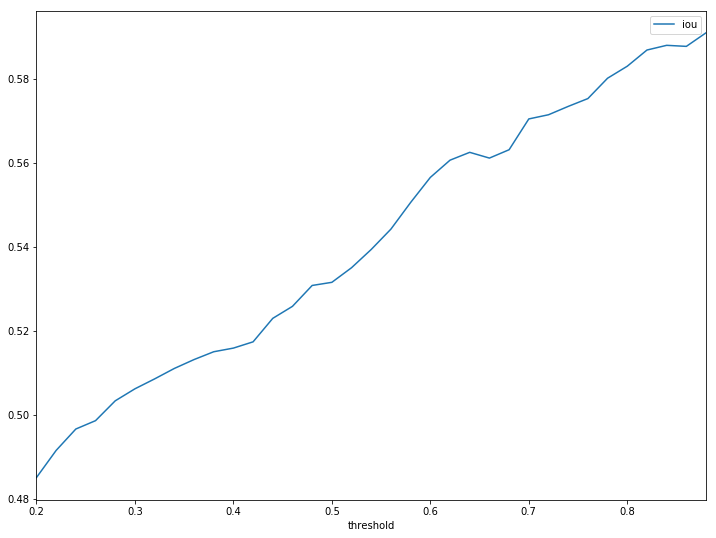

In [27]:
#Plot IoU values over threshold range
df_iou.plot(x='threshold', y='iou')

## 【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。


In [0]:
from keras.applications.vgg19 import VGG19, preprocess_input

#model is parametrized in a way to enable easy change of decoder_block type,
#as this is an argument that ccan be given a function, like decoder_block_simple.
def unet_vgg19(input_size, decoder_block, weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False
               ):
        # weights='imagenet'でResNetの部分はimagenetを利用しての転移学習
        #base model - encoder
        
        base_model = VGG19(
                input_shape=input_size,
                include_top=False,
                weights=weights
        )
        
        #Layers for feature extraction in the encoder part
        encoder1 = base_model.get_layer('block1_conv2').output #224, 224, 64
        encoder2 = base_model.get_layer('block2_conv2').output #112, 112, 128
        encoder3 = base_model.get_layer('block3_conv4').output #56, 56, 256
        encoder4 = base_model.get_layer('block4_conv4').output #28, 28, 512
        encoder5 = base_model.get_layer('block5_conv4').output #14, 14, 512
        
        #Center block
        center = decoder_block(#14, 14, 512
                layer_name=encoder5, block_name='center',
                n_filters=512, conv_dim=(3, 3)
        )
        concat5 = concatenate([center, encoder5], axis=-1)
        
        #Decoder part
        #Every decoder block processed concatenated output from encoder and decoder part.
        #This creates skip connections
        #Afterwards, decoder output is upsampled to dimensions equal to encoder output part
        decoder4 = decoder_block(#14, 14, 512
            layer_name=concat5, block_name='decoder4', n_filters=512, conv_dim=(3, 3)
        )
        concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)
        
        decoder3 = decoder_block(#28, 28, 256
            layer_name=concat4, block_name='decoder3', n_filters=256, conv_dim=(3, 3)
        )
        concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)
        
        decoder2 = decoder_block(#56, 56, 128
            layer_name=concat3, block_name='decoder2', n_filters=128, conv_dim=(3, 3)
        )
        concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)
        
        decoder1 = decoder_block(#112, 112, 256
            layer_name=concat2, block_name='decoder1',  n_filters=64, conv_dim=(3, 3)
        )
        concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)
        
        #Final upsampling and decoder block for segmentation
        
        #output = UpSampling2D()(concat1)
        output = decoder_block(
            #layer_name=output, block_name='decoder_output', n_filters=32, conv_dim=(3, 3)
            layer_name=concat1, block_name='decoder_output', n_filters=32, conv_dim=(3, 3)
        )
        output = Conv2D(
             filters=1, kernel_size=(1, 1), activation=None, name='prediction')(output)
        
        if not use_lovash:
                output = Activation('sigmoid')(output)
        
        model = Model(base_model.input, output)
        model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)
        
        return model

In [29]:
input_size = (224, 224, 3)

K.clear_session()
model = unet_vgg19(
        input_size=input_size, decoder_block=decoder_block_simple, weights='imagenet'
)
model.summary()

80142336/80134624 [==============================] - 6s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________

In [30]:
K.clear_session()

#Build mode:
#Here you can experiment with various losses.
#For dice and BCE(binary_crossentropy), my_iou_metric should be used,
#whereas for lovash_loss my_iou_metric2 should be used, because range of value
#for  lovash loss is between -infty and + infty, not between 0 and 1, as for BCE and dice
#What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
#This is controlled by use_lovash parameter.

model_depth = unet_vgg19(
        input_size=input_size, decoder_block=decoder_block_bottleneck,
        weights='imagenet', loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
        use_lovash=False
)

#print(model_depth.summary())

#bestなepoch回数での結果をcheck_pointに保管するためのModelCheckpointクラスのインスタンス
model_checkpoint = ModelCheckpoint(
        'unet_vgg19.h5', monitor='val_my_iou_metrics', mode='max',
        save_best_only=True, save_weights_only=True, verbose=True
)
#評価値の改善が止まった時に学習率を減少
reduce_lr = ReduceLROnPlateau(
        monitor='val_my_iou_metric',
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-4,
        verbose=True
)

epochs = 10
batch_size = 16

history = model_depth.fit(
        X_tr, y_tr, validation_data=[X_val, y_val],
        epochs=epochs, batch_size=batch_size,
        callbacks=[model_checkpoint, reduce_lr],
        verbose=True
)

Train on 3196 samples, validate on 804 samples
Epoch 1/10
3196/3196 [==============================] - 315s 98ms/step - loss: 0.8989 - my_iou_metric: 0.1498 - val_loss: 2.6237 - val_my_iou_metric: 0.1350
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_my_iou_metrics available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


3196/3196 [==============================] - 292s 91ms/step - loss: 0.7466 - my_iou_metric: 0.2098 - val_loss: 0.8651 - val_my_iou_metric: 0.2330
Epoch 3/10
3196/3196 [==============================] - 292s 91ms/step - loss: 0.6908 - my_iou_metric: 0.2387 - val_loss: 1.1998 - val_my_iou_metric: 0.2752
Epoch 4/10
3196/3196 [==============================] - 292s 91ms/step - loss: 0.6428 - my_iou_metric: 0.2741 - val_loss: 1.0373 - val_my_iou_metric: 0.3553
Epoch 5/10
3196/3196 [==============================] - 292s 91ms/step - loss: 0.6472 - my_iou_metric: 0.2831 - val_loss: 1.3542 - val_my_iou_metric: 0.3590
Epoch 6/10
3196/3196 [==============================] - 292s 91ms/step - loss: 0.6282 - my_iou_metric: 0.3257 - val_loss: 0.7305 - val_my_iou_metric: 0.3352
Epoch 7/10
3196/3196 [==============================] - 292s 91ms/step - loss: 0.5813 - my_iou_metric: 0.3903 - val_loss: 0.7407 - val_my_iou_metric: 0.3602
Epoch 8/10
3196/3196 [==============================] - 292s 91ms/ste

### Validation set prediction and resizing to original size


In [0]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

### Threshold optimization

In [32]:
#Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

#For every threshold, set predictions to binary arrays,
#where values above threshold are treated as 1 and the rest as 0.
#Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true, np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)]
)


100%|██████████| 35/35 [00:51<00:00,  1.45s/it]


Best IoU: 0.5413 at threshold: 0.800


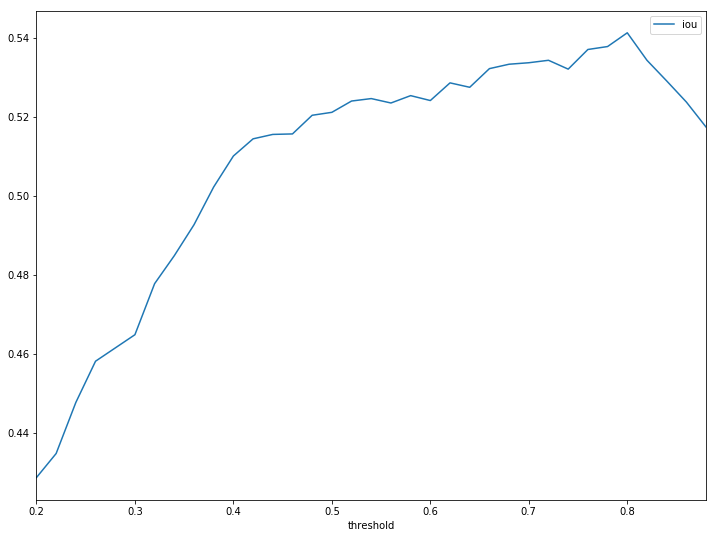

In [33]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

#Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]
))

#Describe IoU DF
df_iou.describe()
#Plot IoU values over threshold range
df_iou.plot(x='threshold', y='iou')

## 【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

問題1, 2の中で実施した。Encoderの層が深いためかResNetの方がIoUが高くなった。